# Getting started
The object-oriented design of MOTorNOT allows declarative construction of virtual experiments. The following examples demonstrate how to define and simulate your own experiment. Make sure to run them in order, as some cells depend on previous ones!

# Generating magnetic fields
Let's start by creating a Coil to generate a magnetic field:

In [1]:
from MOTorNOT.coils import *
radius = 0.1   # 10 cm
z = 0.05          # located 10 cm from the origin
N = 50         # 50 turns
I = 10         # 10 A current
axis = 2       # aligned with z axis
coil = Coil({'radius': 0.08,
             'z': 0.03,
             'N': 50,
             'I': 40,
             'axis': 2
            })

We can calculate the field at a 3D cartesian position X:

In [2]:
X = [0, 0, 0]
coil.field(X)

array([[0.        , 0.        , 0.01207353]])

We can also plot the field:

In [3]:
# coil.plot()

We can generate a quadrupole field by adding another coil to create an anti-Helmholtz pair. The pair of coils will be contained within an instance of the Coils class:

In [4]:
coil2 = Coil({'radius': 0.08,
             'z': -0.03,
             'N': 50,
             'I': -40,
             'axis': 2
            })
coils = Coils([coil, coil2])
# coils.plot()

# Defining laser beams
We can declare a laser beam using a Beam object:

In [5]:
from MOTorNOT.beams import *
wavelength = 399e-9
wavenumber = 2*np.pi/wavelength
linewidth = 26e6

beam = Beam({'wavevector': wavenumber * np.array([0,0,1]),
             'power': 1e-3,
             'radius': 5e-3,
             'detuning': -linewidth/2,
             'handedness': -1
            })


We can form a 1D MOT by adding another beam in the opposite direction and creating a Beams class, which collects multiple Beam objects and calculates the resulting atomic fluorescence in the magnetic field generated by the coils:

In [6]:
beam2 = Beam({'wavevector': wavenumber * np.array([0,0,-1]),
              'power': 1e-3,
              'radius': 5e-3,
              'detuning': -linewidth/2,
              'handedness': -1
             })
beams = Beams([beam, beam2], field = coils.field)
# beams.plot()

# Grating MOTs
The gratingMOT convenience class in gmot.py allows simple construction of a grating magneto-optical trap with arbitrary parameters:

In [7]:
from MOTorNOT.gmot import gratingMOT
period = 600e-9        # 600 nm groove spacing
wavelength = 399e-9    # 399 nm wavelength
linewidth = 26e6

gmot = gratingMOT({'position': 4.5e-3, 
                   'alpha': np.arcsin(wavelength/period), 
                   'radius': 6e-3, 
                   'field': coils.field, 
                   'power': 10e-3, 
                   'detuning': -linewidth/2, 
                   'polarization': -1, 
                   'R1': 1/3})
gmot.plot()

<Figure size 2000x1000 with 9 Axes>

# Integrating atomic trajectories
Let's define initial conditions of a trapping experiment to be 1000 atoms entering along the X axis, with horizontal velocities drawn from a Maxwell-Boltzmann distribution at 450 C:

In [13]:
from MOTorNOT.maxwell_boltzmann import generate_maxwell_boltzmann
N = 100
T = 450+273
X = np.zeros((N, 3))
X[:, 0] = -6e-3
V = np.zeros((N, 3))
vmin = 0.1
vmax = 20
V[:, 0] = np.linspace(vmin, vmax, N)

# V[:, 0] = generate_maxwell_boltzmann(T, N)


Now let's simulate the trap dynamics for 20 ms:

99.6% done; estimated time remaining: 0 s                                                                                    

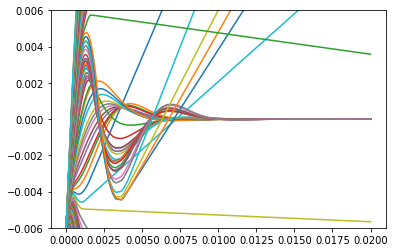

In [18]:
from MOTorNOT.integration import Solver
tmax = 20e-3
sol = Solver(X, V, gmot.force, None, duration = tmax)
x, v = sol.solve()
sol.plot(x)
